In [1]:
import numpy
import tensorboard as tensorboard
import seaborn as seaborn
from tensorflow.python.client import device_lib
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kr
print('tensorflow' + tf.__version__)
print('tensorboard' + tensorboard.__version__)
print('seaborn' + seaborn.__version__)
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

tensorflow2.1.0
tensorboard2.1.0
seaborn0.10.1
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14220462354948271016,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6588305899
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1224590318479180020
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"]

In [2]:
data_dir="../input/kaggle-flowers"
test_path= os.path.join(data_dir, 'test')

os.listdir(test_path)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

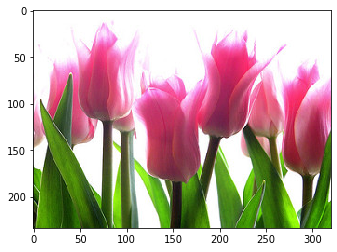

In [3]:
tulip_image = test_path + '/tulip/' + os.listdir(test_path + '/tulip')[6]
imread(tulip_image).shape
plt.imshow(imread(tulip_image))

In [4]:
image_shape =(250, 250, 3)
test_gen = ImageDataGenerator(rescale =1./255)
batch_size=32
test_image_gen= test_gen.flow_from_directory(test_path, target_size=image_shape[:2], 
                                               color_mode='rgb', batch_size=batch_size, 
                                               class_mode='categorical',  shuffle=False)
test_image_gen.class_indices

Found 750 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [5]:
model =tf.keras.models.load_model('flowers')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 247, 247, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

[1, 2]
[1.1920930376163594e-07, 1.1920930376163594e-07]


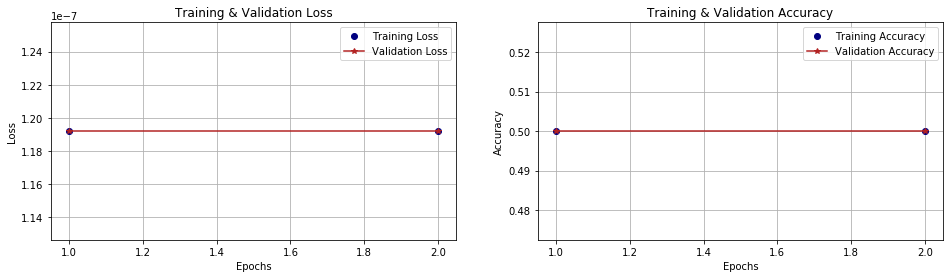

In [6]:
history = pd.read_csv("history_catsdogs.csv")
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [7]:
pred = model.predict(test_image_gen)

In [8]:
predictions=[]
for values in pred:
    predictions.append(numpy.where(values == numpy.amax(values))[0][0])

In [9]:
# predictions = pred > 0.5
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71       150
           1       0.73      0.73      0.73       150
           2       0.66      0.79      0.72       150
           3       0.83      0.83      0.83       150
           4       0.70      0.77      0.73       150

    accuracy                           0.75       750
   macro avg       0.76      0.75      0.74       750
weighted avg       0.76      0.75      0.74       750



In [10]:
confusion_matrix(test_image_gen.classes, predictions)

array([[ 90,  26,  20,   4,  10],
       [  3, 110,   7,  20,  10],
       [  8,   7, 119,   0,  16],
       [  2,   5,   5, 125,  13],
       [  1,   2,  30,   2, 115]], dtype=int64)

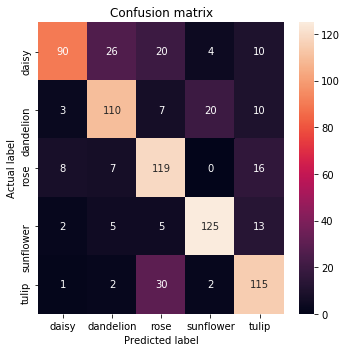

In [11]:

kr.plot_cm_categorical(test_image_gen.classes, predictions, test_image_gen.class_indices)

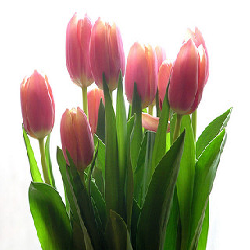

In [12]:
from tensorflow.keras.preprocessing import image
dog_image_path = test_path + '/tulip/' + os.listdir(test_path + '/tulip/')[5]
# plt.imshow(imread(dog_image))
my_image = image.load_img(dog_image_path, target_size=image_shape)
my_image

In [13]:
my_img_arr = image.img_to_array(my_image)
my_img_arr.shape
my_img_arr = np.expand_dims(my_img_arr, axis =0)
my_img_arr.shape

(1, 250, 250, 3)

In [14]:
model.predict_classes(my_img_arr)

array([4], dtype=int64)

In [15]:
model.input.shape

TensorShape([None, 250, 250, 3])

In [16]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (4, 4, 3, 32)
conv2d_1 (4, 4, 32, 32)
conv2d_2 (4, 4, 32, 64)


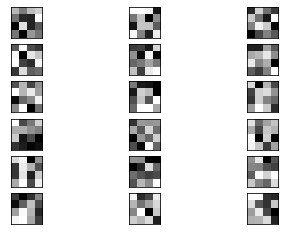

In [17]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

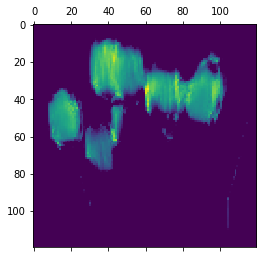

In [18]:
from tensorflow.keras import models
# extracts the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]

# creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.inputs, outputs=model.layers[2].output)

# returns a list of Numpy arrays: one array per layer activation
feature_maps  = activation_model.predict(my_img_arr)

# activation of the 1st convolution layer
first_layer_activation = feature_maps[0]

# # display the 4th channel of the activation of the 1st layer of the original model
plt.matshow(feature_maps[0, :, :, 1], cmap='viridis')

In [19]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 247, 247, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      16416     
Total params: 17,984
Trainable params: 17,984
Non-trainable params: 0
_________________________________________________________________


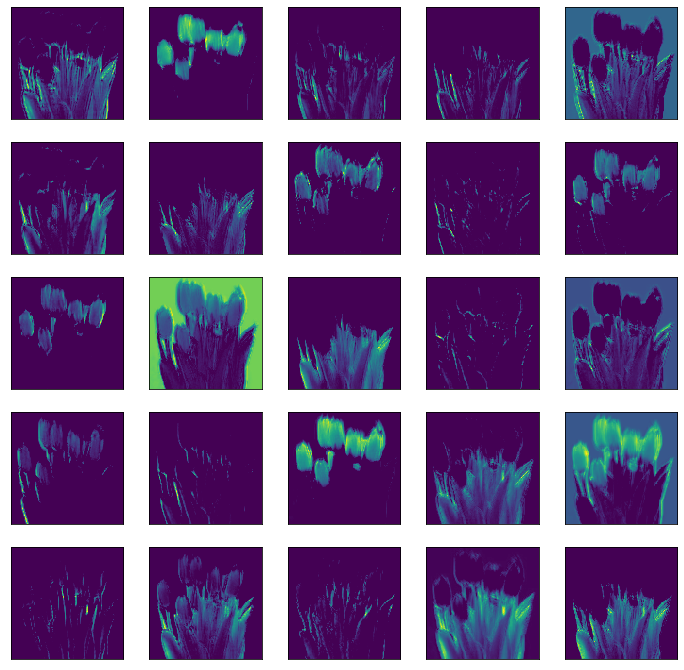

In [20]:

# plot all 64 maps in an 8x8 squares
square = 5
ix = 1
plt.figure(figsize=(12,12))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure

plt.show()

In [21]:
from keras.applications.imagenet_utils import decode_predictions 
resnet = tf.keras.applications.ResNet152()


Using TensorFlow backend.


[[('n03876231', 'paintbrush', 0.4186626), ('n03991062', 'pot', 0.16554993), ('n11939491', 'daisy', 0.16379529), ('n04522168', 'vase', 0.15155655), ('n12985857', 'coral_fungus', 0.019964285)]]
Predicted: paintbrush


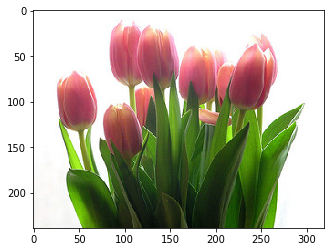

In [22]:
dog_image_path = test_path + '/tulip/' + os.listdir(test_path + '/tulip/')[5]
# plt.imshow(imread(dog_image))
sample_image = image.load_img(dog_image_path, target_size=(224, 224, 3))
plt.imshow(imread(dog_image_path))
sample_img_arr = image.img_to_array(sample_image)
sample_img_arr = np.expand_dims(sample_img_arr, axis =0)
predictions = resnet.predict(sample_img_arr)
print(decode_predictions(predictions))
print('Predicted:', decode_predictions(predictions, top=3)[0][0][1])

In [23]:
print(predictions[0])

[2.02636343e-08 1.31590025e-06 5.12607592e-08 4.82351181e-09
 1.12356453e-07 3.25567470e-07 5.16885805e-08 3.72819959e-05
 3.41674365e-07 3.56062024e-08 2.96511473e-07 4.98401675e-07
 1.46438325e-07 1.27427938e-07 9.99712739e-08 1.19441424e-07
 1.57509403e-05 6.90023512e-07 3.03844814e-07 2.97490215e-06
 1.68650449e-09 5.34021751e-08 1.30429783e-07 1.39132208e-05
 3.71855293e-08 2.82041359e-08 8.96841101e-10 7.08007946e-08
 1.19267893e-08 4.04727523e-08 1.74014350e-08 3.49809466e-06
 4.22287698e-08 4.40773675e-08 2.47470695e-07 3.59032515e-09
 1.03433607e-07 4.25001865e-08 1.19437038e-08 2.49771290e-07
 2.38752341e-06 4.01390245e-08 2.10787732e-07 4.01363458e-08
 2.25239010e-08 1.08030667e-06 5.64903985e-06 9.10221871e-08
 3.89013302e-08 2.17672973e-08 1.06509477e-08 1.00905891e-06
 3.47188700e-09 5.53261259e-08 1.35693741e-08 1.30423317e-07
 3.55302916e-08 1.47979291e-08 3.24214739e-07 1.30252019e-07
 9.51596490e-08 5.59915883e-08 8.47350634e-09 1.67974363e-07
 3.81339476e-07 5.639549

In [24]:
sum(predictions[0])

1.000000024640983

In [25]:
pred

array([[1.08512715e-01, 5.52855670e-01, 3.73035371e-02, 2.61178434e-01,
        4.01495621e-02],
       [9.97642040e-01, 1.02058996e-03, 8.54241080e-04, 4.67128521e-05,
        4.36292641e-04],
       [1.88297376e-01, 7.02901036e-02, 4.46528196e-01, 1.86102372e-02,
        2.76274115e-01],
       ...,
       [9.11736520e-10, 4.59307384e-11, 1.71143597e-03, 4.20637913e-10,
        9.98288572e-01],
       [1.84825694e-04, 1.03289189e-04, 4.70409915e-02, 1.91101775e-04,
        9.52479839e-01],
       [1.84102745e-07, 1.22955708e-08, 1.94991403e-03, 5.21844072e-07,
        9.98049378e-01]], dtype=float32)

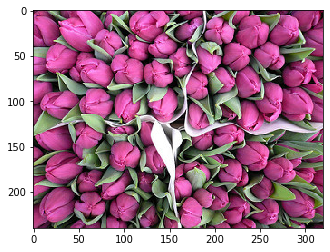

In [42]:
dog_image_path = test_path + '/tulip/' + os.listdir(test_path + '/tulip/')[20]
# plt.imshow(imread(dog_image))
sample_image = image.load_img(dog_image_path, target_size=(250, 250, 3))
plt.imshow(imread(dog_image_path))
sample_img_arr = image.img_to_array(sample_image)
# standardized_image = test_gen.standardize(sample_img_arr)

import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(sample_img_arr, model.predict)

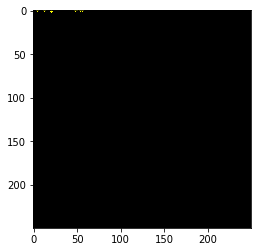

In [43]:
from skimage.segmentation import mark_boundaries
# Get image and mask shows us the superpixels that the model found to be
# most relevant to making a prediction
# The argument with the value of 1 in this method is the class that we want LIME to explain
# temp, mask = explanation.get_image_and_mask(0, positive_only=True, hide_rest=True, num_features = 5)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0] , positive_only=False, 
                                            negative_only=False, hide_rest=True, num_features = 5, min_weight=0)

plt.imshow(mark_boundaries(temp , mask))


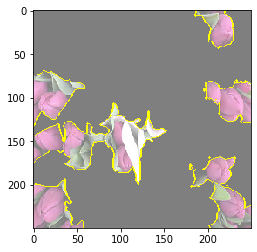

In [28]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

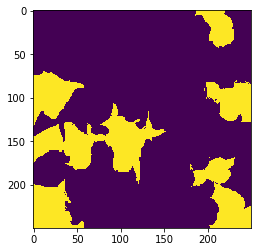

In [29]:
plt.imshow(mask.astype(np.uint8))

In [30]:
model.predict_classes(np.expand_dims(sample_image, axis =0))

array([2], dtype=int64)

In [31]:
# !pip install lime -U

In [39]:
dog_image_path = test_path + '/tulip/' + os.listdir(test_path + '/tulip/')
# plt.imshow(imread(dog_image))
sample_image = image.load_img(dog_image_path, target_size=(250, 250, 3))
plt.imshow(imread(dog_image_path))
sample_img_arr = image.img_to_array(sample_image)

TypeError: can only concatenate str (not "list") to str

In [41]:
help(image)

NameError: name 'tensorflow' is not defined

In [35]:
import shap
import numpy as np
e = shap.DeepExplainer(model, sample_img_arr.reshape(1,250,250,3))
shap_values = e.shap_values(test_image_gen)
shap.image_plot(shap_values, -x_test[1:5])

StagingError: in converted code:

    C:\Users\dan39\Anaconda3\lib\site-packages\shap\explainers\deep\deep_tf.py:243 grad_graph  *
        self._init_between_tensors(out.op, shap_rAnD)
    C:\Users\dan39\Anaconda3\lib\site-packages\shap\explainers\deep\deep_tf.py:181 _init_between_tensors  *
        tensor_blacklist = tensors_blocked_by_false(self.learning_phase_ops) # don't follow learning phase branches
    C:\Users\dan39\Anaconda3\lib\site-packages\shap\explainers\deep\deep_tf.py:427 recurse  *
        for c in out.consumers():
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:57 recurse
        ag__.if_stmt(cond, if_true, if_false, get_state_2, set_state_2, (), ())
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:920 if_stmt
        return _py_if_stmt(cond, body, orelse)
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:1029 _py_if_stmt
        return body() if cond else orelse()
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:54 if_false
        ag__.for_stmt(op.outputs, None, loop_body_1, get_state_1, set_state_1, (), (), ())
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:339 for_stmt
        return _py_for_stmt(iter_, extra_test, body, get_state, set_state, init_vars)
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:350 _py_for_stmt
        state = body(target, *state)
    C:\Users\dan39\AppData\Local\Temp\tmprsgs2k1r.py:52 loop_body_1
        ag__.for_stmt(ag__.converted_call(out.consumers, (), None, fscope_1), None, loop_body, get_state, set_state, (), (), ())
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\impl\api.py:405 converted_call
        if conversion.check_cached_unconverted(f, options):
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\impl\conversion.py:436 check_cached_unconverted
        return _UNCONVERTED_CACHE.has(entity, options)
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\autograph\impl\conversion.py:113 has
        if key not in self._cache:
    C:\Users\dan39\Anaconda3\lib\weakref.py:440 __contains__
        return wr in self.data
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:703 __hash__
        if (Tensor._USE_EQUALITY and executing_eagerly_outside_functions() and
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:5545 executing_eagerly_outside_functions
        outer_context, _ = _get_outer_context_and_inner_device_stack()
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:5400 _get_outer_context_and_inner_device_stack
        default_graph = get_default_graph()
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:5778 get_default_graph
        return _default_graph_stack.get_default()
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:5359 get_default
        ret = super(_DefaultGraphStack, self).get_default()
    C:\Users\dan39\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:5171 get_default
        return self.stack[-1] if len(self.stack) >= 1 else None

    RecursionError: maximum recursion depth exceeded in comparison
